# Fit an Ising model to the concentration data that we have as described in Broderick et al. 2007 
https://arxiv.org/abs/0712.2437

In [4]:
import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap, lax, jit, tree_util, nn
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from matplotlib.gridspec import GridSpec
import pandas as pd

In [5]:
DATA_PATH = '../vcf/Matrix2.csv'

In [242]:
class OlfactionIsingModel:
    def __init__(self, data_path):
        self.data_path = data_path
        self.load_data() 
    
    def load_data(self): 
        self.data = pd.read_csv(self.data_path, index_col=0) 

    def subset_top_n_odorants(self, n):
        sums = jnp.sum(self.data.values, axis=1)
        cutoff_value = jnp.sort(sums)[-n]
        indices = jnp.where(sums >= cutoff_value)[0]
        filtered_data = self.data.iloc[indices, :] 
        self.top_n_data = filtered_data
        return filtered_data
    
    def downsample_odorants(self, key, fraction=.01): 
        num_rows = self.data.shape[0]
        indices = jax.random.choice(key, jnp.arange(num_rows), shape=(int(fraction * num_rows), ))
        self.downsampled_data = self.data.iloc[indices, :]

    def energy(self, s, h, J): 
        return - (h @ s + s @ J @ s)
    
    def sample_from_ising_model(self, key, h, J, s_init = None, iters=1, beta=1):
        if s_init is None: 
            s_init = 2 * jax.random.bernoulli(key, p=0.5, shape=(len(h),)) - 1
        s = s_init
        vals = jnp.zeros((len(s), iters + 1))
        vals = vals.at[:, 0].set(s) 
        for iter in range(1, iters + 1): 
            key, subkey = jax.random.split(key) 
            i = jax.random.choice(subkey, jnp.arange(len(s)))
            # see https://sites.stat.washington.edu/mmp/courses/stat534/spring19/Handouts/lecture-may21.pdf for an easy overview of how conditional prob becomes sigmoid
            contribution = beta * (h[i] + J[i, :] @ s) 
            p_plus = nn.sigmoid(2 * contribution) 
            if jax.random.uniform(subkey) < p_plus: 
                s = s.at[i].set(1)
            else:
                s = s.at[i].set(-1)
            vals = vals.at[:, iter].set(s) 
        return vals 
    
    def autocorrelation(self, chain, lag):
        """Compute autocorrelation at a given lag."""
        n = len(chain)
        mean = jnp.mean(chain)
        var =  jnp.var(chain)
        if var == 0:
            return 0
        return jnp.sum((chain[:n-lag] - mean) * (chain[lag:] - mean)) / (var * (n - lag))

    def estimate_autocorrelation_time(self, chain, max_lag=100):
        """Estimate the autocorrelation time."""
        autocorrs = [self.autocorrelation(chain, lag) for lag in range(max_lag)]
        return autocorrs
        for lag, corr in enumerate(autocorrs):
            if corr < 0.1:  # Threshold for approximate independence
                return lag
        return max_lag  # Return max_lag if no decorrelation is found

In [232]:
oim = OlfactionIsingModel(DATA_PATH)

In [233]:
key = jax.random.PRNGKey(3) 

In [234]:
oim.downsample_odorants(key, fraction=.005)

In [235]:
h = jnp.zeros(len(oim.downsampled_data))
J = jnp.ones((oim.downsampled_data.shape[0], oim.downsampled_data.shape[0]))

In [236]:
betas = jnp.logspace(-3, 0, 5) 

In [240]:
betas[2] 

Array(0.03162277, dtype=float32)

Text(0.5, 0, 'iteration')

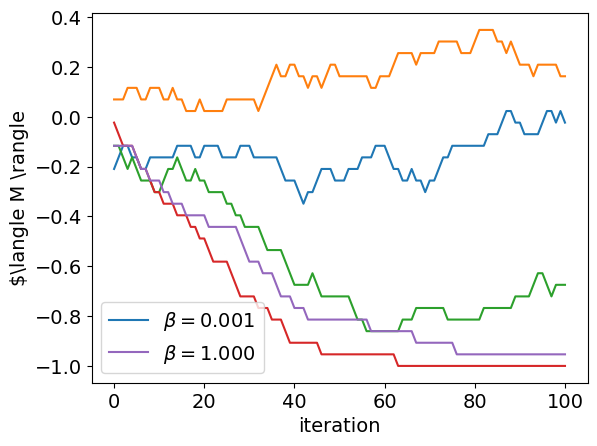

In [239]:
fig, ax = plt.subplots()

for i, beta in enumerate(betas): 
    key = jax.random.PRNGKey(i)
    vals = oim.sample_from_ising_model(key, h, J, iters=100, beta=beta)
    if i == 0 or i == len(betas) - 1: 
        label = rf'$\beta = {beta:.3f}$'
    else: 
        label = ''
    ax.plot(1 / vals.shape[0] * vals.sum(axis=0), label=label) 
ax.legend() 
ax.set_ylabel(r'$\langle M \rangle')
ax.set_xlabel('iteration')


In [241]:
vals = oim.sample_from_ising_model(key, h, J, iters=10000, beta=.03)

In [244]:
v = vals[:, 1000:]

In [246]:
m = jnp.sum(v, axis=0) 

In [250]:
autocorrs = oim.estimate_autocorrelation_time(m) 

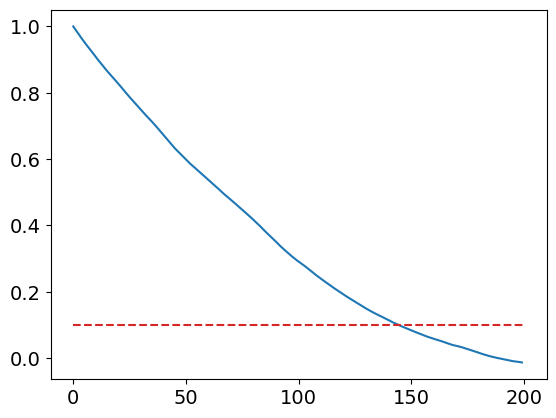

In [265]:
acs = [oim.autocorrelation(m, lag=l) for l in range(200)] 
plt.plot(range(200), acs)
plt.hlines(.1, 0, 200, ls='--', color='tab:red')

In [267]:
v.shape

(43, 9001)

In [269]:
v[:, ::150].shape

(43, 61)

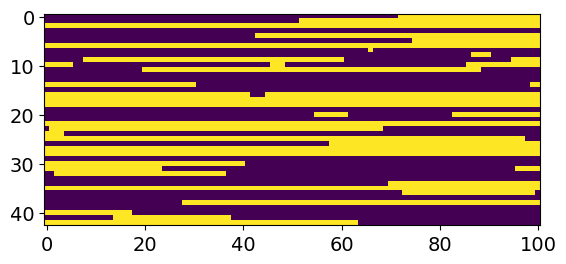

In [229]:
plt.imshow

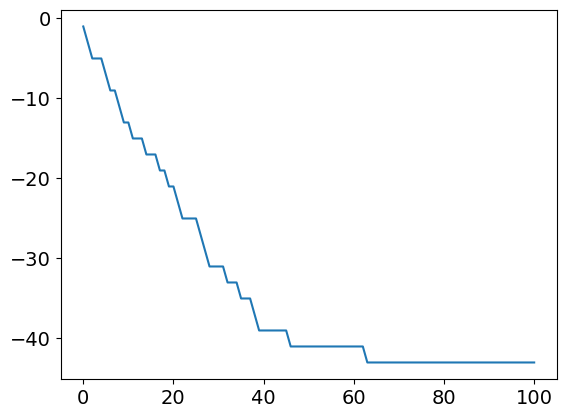

In [201]:
plt.plot(vals.sum(axis=0)[:])

In [24]:
cov = jnp.cov(oim.downsampled_data.values) 

In [25]:
eig = jnp.linalg.eig(cov) 

In [29]:
10**-.3

0.5011872336272722

In [30]:
fractions = jnp.array([.01, .03, .1, .3, .5]) 

<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
/var/folders/qq/1ty9_n0n2rq91n4gcs0zkk440000gn/T/ipykernel_142/3485104052.py:6: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('Spectrum of $\hat{\Sigma}$')
/Users/juancarlos/miniforge3/envs/olfaction/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/juancarlos/miniforge3/envs/olfaction/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


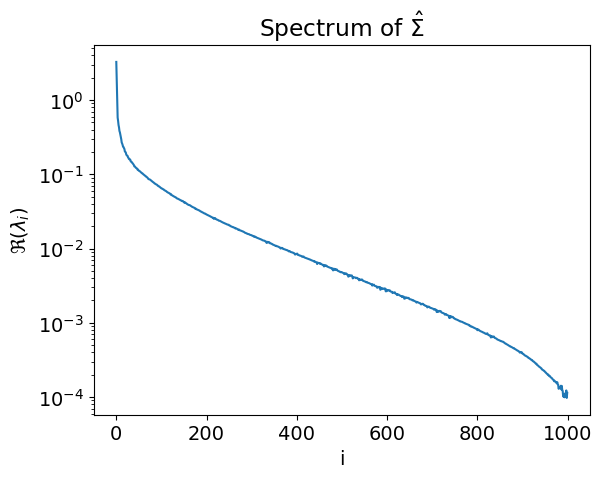

In [39]:
fig, ax = plt.subplots()
ax.plot(eig[0][:1000]) 
ax.set_yscale('log') 
ax.set_xlabel('i')
ax.set_ylabel(r'$\Re(\lambda_i)$')
ax.set_title('Spectrum of $\hat{\Sigma}$')
fig.savefig('eigenvalue_spectrum_50_percent_downsampled.png') 

0.01
0.03
0.1
0.3
0.5


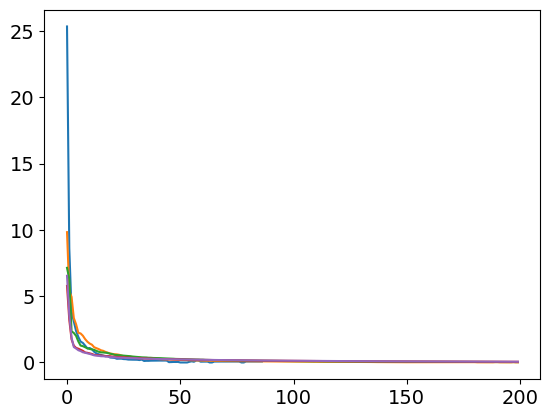

In [32]:
fig, ax = plt.subplots()
for frac in fractions: 
    print(frac) 
    oim.downsample_odorants(key, fraction=frac) 
    cov = jnp.cov(oim.downsampled_data.values) 
    eig = jnp.linalg.eig(cov)
    ax.plot(jnp.real(eig[0][:200]) / frac) 

In [164]:
oim.subset_top_n_odorants(10)

,ALMOND_HULL_(mission)_10103.html,CHESTNUT_FLOWER_27470.html,ITALIAN_CHESTNUT_(Castanea_sativa_Mill.)_(raw)_27450.html,COCONUT_MILK_8330.html,GREEN_WALNUT_HUSK_(dried_unripe)(Juglans_regia_L.)_10840.html,MACADAMIA_NUT_(Macadamia_integrifolia)_(roasted)_10210.html,ITALIAN_CHESTNUT_(Castanea_sativa_Mill.)_(roasted)_27410.html,PISTACHIO_NUT_(Pistacia_vera)_(roasted)_19620.html,CHINESE_CHESTNUT_(Castanea_molissima)_(boiled)_27440.html,ALMOND_(roasted)_(Prunus_amygdalus)_10101.html,...,POTATO_(raw)_2510.html,BEANS_(raw)_9210.html,POTATO_(cooked_or_boiled)_2540.html,DEFATTED_SOYBEAN_8220.html,NOBIRU_(Allium_grayi_Regal)_2390.html,CABBAGE_(cooked)_1820.html,CHINESE_CABBAGE_21320.html,WELSH_ONION_(Allium_fistulosum_L._var._maichuon)_2392.html,RADISH_(raw)_12610.html,CHILI_PEPPER_PERICARP_(C._baccatum)_2625.html
&alpha;-terpineol (=p-1-menthen-8-ol),0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1-hexanol,1,0,0,1,1,1,1,0,0,0,...,1,1,1,1,1,1,1,0,1,0
1-pentanol (=amyl alcohol),0,0,0,0,0,1,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
2-phenylethanol,1,1,0,0,0,1,1,1,0,0,...,0,1,1,0,0,0,1,0,0,0
3-methyl-1-butanol (=isoamyl alcohol),0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
benzaldehyde,1,1,0,0,0,1,1,0,0,1,...,1,1,1,0,0,1,0,0,0,0
hexanal,1,1,0,0,1,1,1,1,1,0,...,1,1,1,1,1,1,0,0,1,0
limonene,0,1,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
linalool,1,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
nonanal (=pelargonaldehyde),1,1,0,0,1,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [162]:
oim.downsample_odorants(key) 

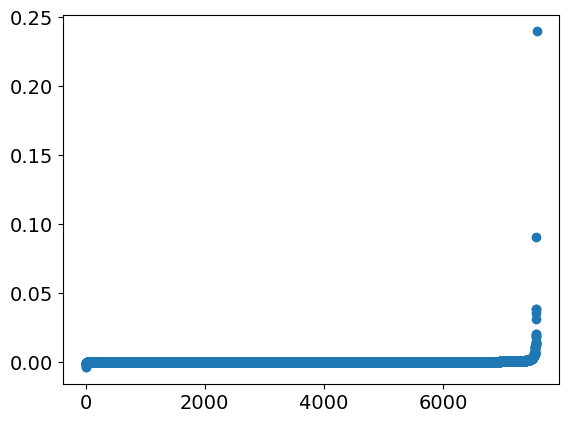

In [146]:
covs = jnp.cov(oim.downsampled_data.values).flatten() 
plt.scatter(range(len(covs)), jnp.sort(covs))

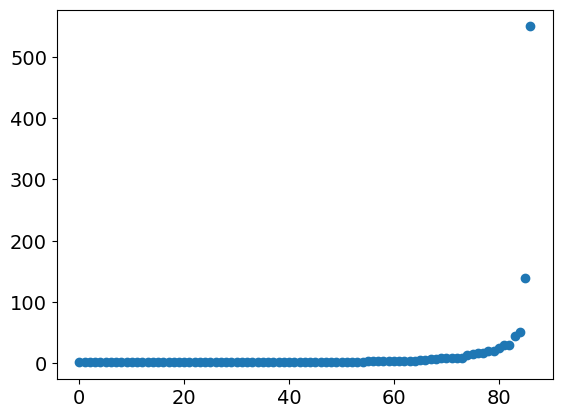

In [126]:
sums = jnp.sum(oim.downsampled_data.values, axis=1) 
plt.scatter(range(len(sums)), jnp.sort(sums))

In [127]:
sums

Array([  1,   2,   1,   2,   1,   1,   1,  51,  14,   1,   3,   1,   1,
         1,   8,   1,   1,   3, 550,   1,   1,   1,   2,  29,   1,   5,
         1,   4,   1,   2,   3,   9,   1,   2,   1,   8,   1,  44,   4,
        19,   9,   2,   1,   1,   2,   3,   8,   1,   7,   5,   1,   1,
         1,   2,   1,   3,   1,   1,   1,  15,   4,   3,  19,   1,   1,
         2,  29,   1,   1,   1,   1,   1,   1,  25,   1, 139,  16,  17,
         2,   4,   1,   6,   1,   1,   1,   2,   1], dtype=int32)